# CNN Classifier for Algae Microscopy Images

This notebook trains a Convolutional Neural Network (CNN) using PyTorch to classify algae species based on microscopy images.

## Features:
- Custom CNN architecture
- Hyperparameter tuning with GridSearchCV
- Training on train set
- Evaluation on test set
- Configurable hyperparameters for easy fine-tuning

In [11]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import yaml
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(30)
np.random.seed(30)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Configuration and Hyperparameters

All hyperparameters are defined here for easy tuning.

In [12]:
# Load configuration
config_path = Path('../configs/config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Data paths
DATA_ROOT = Path('../data')
TRAIN_IMAGES = DATA_ROOT / 'train' / 'images'
TRAIN_LABELS = DATA_ROOT / 'train' / 'labels'
TEST_IMAGES = DATA_ROOT / 'test' / 'images'
TEST_LABELS = DATA_ROOT / 'test' / 'labels'

# Class information
CLASS_NAMES = config['data']['classes']
NUM_CLASSES = len(CLASS_NAMES)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Number of classes: 6
Classes: ['Platymonas', 'Chlorella', 'Dunaliella salina', 'Effrenium', 'Porphyridium', 'Haematococcus']


In [13]:
# ============================================
# HYPERPARAMETERS - Modify these for tuning
# ============================================

# Image parameters
IMAGE_SIZE = 224  # Input image size

# Training parameters (for GridSearchCV)
PARAM_GRID = {
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0001],
    'num_epochs': [20],  # Start with fewer epochs for grid search
    'dropout': [0.3, 0.5],
    'optimizer': ['adam', 'sgd']
}

# Model architecture parameters
USE_PRETRAINED = True  # Use pretrained ResNet18 as backbone
FREEZE_BACKBONE = False  # Whether to freeze backbone weights

# Data augmentation parameters
AUGMENTATION_PARAMS = {
    'horizontal_flip': 0.5,
    'vertical_flip': 0.5,
    'rotation': 30,  # degrees
    'brightness': 0.2,
    'contrast': 0.2
}

# Other parameters
NUM_WORKERS = 0
SAVE_DIR = Path('../outputs/models')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("Hyperparameters configured successfully!")

Hyperparameters configured successfully!


## 2. Dataset Class

In [14]:
class AlgaeDataset(Dataset):
    """
    Custom Dataset for Algae Classification.
    Reads images and their corresponding labels from YOLO format.
    """
    
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.label_dir = Path(label_dir)
        self.transform = transform
        
        # Get all image paths
        self.image_paths = sorted(list(self.image_dir.glob('*.jpg')))
        
        # Filter to only include images with labels
        self.valid_samples = []
        for img_path in self.image_paths:
            label_path = self.label_dir / (img_path.stem + '.txt')
            if label_path.exists():
                self.valid_samples.append((img_path, label_path))
        
        print(f"Found {len(self.valid_samples)} valid samples")
    
    def __len__(self):
        return len(self.valid_samples)
    
    def __getitem__(self, idx):
        img_path, label_path = self.valid_samples[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Load label (YOLO format: class_id x_center y_center width height)
        with open(label_path, 'r') as f:
            # Take the first object's class (assuming single class per image)
            line = f.readline().strip()
            if line:
                class_id = int(line.split()[0])
            else:
                class_id = 0  # Default to first class if no label
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, class_id

print("Dataset class defined!")

Dataset class defined!


## 3. Data Transforms

In [15]:
# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=AUGMENTATION_PARAMS['horizontal_flip']),
    transforms.RandomVerticalFlip(p=AUGMENTATION_PARAMS['vertical_flip']),
    transforms.RandomRotation(AUGMENTATION_PARAMS['rotation']),
    transforms.ColorJitter(
        brightness=AUGMENTATION_PARAMS['brightness'],
        contrast=AUGMENTATION_PARAMS['contrast']
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined!")

Transforms defined!


## 4. CNN Model Architecture

In [16]:
class AlgaeCNN(nn.Module):
    """
    CNN model for algae classification.
    Uses ResNet18 as backbone with custom classifier head.
    """
    
    def __init__(self, num_classes=6, dropout=0.5, use_pretrained=True):
        super(AlgaeCNN, self).__init__()
        
        # Load ResNet18 backbone
        if use_pretrained:
            self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        else:
            self.backbone = resnet18(weights=None)
        
        # Get the number of features from the backbone
        num_features = self.backbone.fc.in_features
        
        # Replace the final fully connected layer
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)
    
    def freeze_backbone(self):
        """Freeze all layers except the final classifier."""
        for param in self.backbone.parameters():
            param.requires_grad = False
        # Unfreeze the final classifier
        for param in self.backbone.fc.parameters():
            param.requires_grad = True

print("Model architecture defined!")

Model architecture defined!


## 5. Training Function

In [17]:
def train_model(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model on test set.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

print("Training functions defined!")

Training functions defined!


## 6. GridSearchCV Implementation

In [18]:
def grid_search_cv(param_grid, train_dataset, test_dataset):
    """
    Perform grid search over hyperparameters.
    """
    results = []
    best_acc = 0
    best_params = None
    best_model = None
    
    # Generate all parameter combinations
    param_combinations = list(ParameterGrid(param_grid))
    print(f"\nTesting {len(param_combinations)} parameter combinations...\n")
    
    for i, params in enumerate(param_combinations):
        print(f"\n{'='*60}")
        print(f"Combination {i+1}/{len(param_combinations)}")
        print(f"Parameters: {params}")
        print(f"{'='*60}\n")
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=params['batch_size'],
            shuffle=True,
            num_workers=NUM_WORKERS
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=params['batch_size'],
            shuffle=False,
            num_workers=NUM_WORKERS
        )
        
        # Create model
        model = AlgaeCNN(
            num_classes=NUM_CLASSES,
            dropout=params['dropout'],
            use_pretrained=USE_PRETRAINED
        ).to(device)
        
        if FREEZE_BACKBONE:
            model.freeze_backbone()
        
        # Define loss and optimizer
        criterion = nn.CrossEntropyLoss()
        
        if params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        else:
            optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)
        
        # Training loop
        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []
        
        for epoch in range(params['num_epochs']):
            print(f"\nEpoch {epoch+1}/{params['num_epochs']}")
            
            # Train
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            # Evaluate
            test_loss, test_acc, _, _ = evaluate_model(model, test_loader, criterion, device)
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        
        # Store results
        final_test_acc = test_accs[-1]
        results.append({
            'params': params,
            'test_acc': final_test_acc,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accs': train_accs,
            'test_accs': test_accs
        })
        
        # Update best model
        if final_test_acc > best_acc:
            best_acc = final_test_acc
            best_params = params
            best_model = model
        
        print(f"\nFinal Test Accuracy: {final_test_acc:.2f}%")
    
    return results, best_params, best_model, best_acc

print("GridSearchCV function defined!")

GridSearchCV function defined!


## 7. Load Data and Run Grid Search

In [19]:
# Create datasets
print("Loading datasets...")
train_dataset = AlgaeDataset(TRAIN_IMAGES, TRAIN_LABELS, transform=train_transform)
test_dataset = AlgaeDataset(TEST_IMAGES, TEST_LABELS, transform=test_transform)

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Loading datasets...
Found 700 valid samples
Found 300 valid samples

Train dataset size: 700
Test dataset size: 300


In [20]:
# Run grid search
print("\nStarting Grid Search...\n")
results, best_params, best_model, best_acc = grid_search_cv(
    PARAM_GRID,
    train_dataset,
    test_dataset
)

print(f"\n{'='*60}")
print("GRID SEARCH COMPLETE")
print(f"{'='*60}")
print(f"\nBest Parameters: {best_params}")
print(f"Best Test Accuracy: {best_acc:.2f}%")


Starting Grid Search...


Testing 16 parameter combinations...


Combination 1/16
Parameters: {'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.001, 'num_epochs': 20, 'optimizer': 'adam'}


Epoch 1/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


Train Loss: 1.5258, Train Acc: 37.71%
Test Loss: 2.7085, Test Acc: 24.67%

Epoch 2/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


Train Loss: 1.3724, Train Acc: 45.29%
Test Loss: 1.8217, Test Acc: 18.67%

Epoch 3/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]


Train Loss: 1.3339, Train Acc: 47.71%
Test Loss: 1.6474, Test Acc: 24.33%

Epoch 4/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]


Train Loss: 1.2752, Train Acc: 48.29%
Test Loss: 1.5826, Test Acc: 42.33%

Epoch 5/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Train Loss: 1.1933, Train Acc: 52.57%
Test Loss: 1.5208, Test Acc: 47.33%

Epoch 6/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]


Train Loss: 1.2446, Train Acc: 50.43%
Test Loss: 2.1983, Test Acc: 12.33%

Epoch 7/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]


Train Loss: 1.1202, Train Acc: 56.14%
Test Loss: 1.5399, Test Acc: 32.67%

Epoch 8/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]


Train Loss: 1.1550, Train Acc: 55.29%
Test Loss: 1.8841, Test Acc: 27.33%

Epoch 9/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]


Train Loss: 1.1219, Train Acc: 58.29%
Test Loss: 2.1849, Test Acc: 14.00%

Epoch 10/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Train Loss: 1.0622, Train Acc: 62.86%
Test Loss: 1.8644, Test Acc: 31.00%

Epoch 11/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]


Train Loss: 1.0484, Train Acc: 62.29%
Test Loss: 1.7486, Test Acc: 29.33%

Epoch 12/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.17it/s]


Train Loss: 1.0634, Train Acc: 61.43%
Test Loss: 2.0727, Test Acc: 30.67%

Epoch 13/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]


Train Loss: 1.0831, Train Acc: 62.29%
Test Loss: 2.1426, Test Acc: 33.33%

Epoch 14/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Train Loss: 1.0200, Train Acc: 63.57%
Test Loss: 1.8324, Test Acc: 27.33%

Epoch 15/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


Train Loss: 1.0190, Train Acc: 62.57%
Test Loss: 1.6652, Test Acc: 32.67%

Epoch 16/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Train Loss: 0.9582, Train Acc: 65.86%
Test Loss: 1.7168, Test Acc: 35.00%

Epoch 17/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]


Train Loss: 0.9594, Train Acc: 66.57%
Test Loss: 1.7324, Test Acc: 34.33%

Epoch 18/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]


Train Loss: 0.9954, Train Acc: 66.29%
Test Loss: 1.7927, Test Acc: 38.00%

Epoch 19/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Train Loss: 0.9890, Train Acc: 66.00%
Test Loss: 2.1718, Test Acc: 27.33%

Epoch 20/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Train Loss: 0.9441, Train Acc: 65.86%
Test Loss: 1.7883, Test Acc: 32.33%

Final Test Accuracy: 32.33%

Combination 2/16
Parameters: {'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.001, 'num_epochs': 20, 'optimizer': 'sgd'}


Epoch 1/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]


Train Loss: 1.8164, Train Acc: 18.43%
Test Loss: 1.7021, Test Acc: 17.00%

Epoch 2/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Train Loss: 1.7468, Train Acc: 24.00%
Test Loss: 1.6210, Test Acc: 35.67%

Epoch 3/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.88it/s]


Train Loss: 1.6115, Train Acc: 36.29%
Test Loss: 1.5700, Test Acc: 34.67%

Epoch 4/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]


Train Loss: 1.4153, Train Acc: 43.57%
Test Loss: 1.5365, Test Acc: 42.33%

Epoch 5/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Train Loss: 1.2410, Train Acc: 50.71%
Test Loss: 1.6084, Test Acc: 39.33%

Epoch 6/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


Train Loss: 1.1243, Train Acc: 56.43%
Test Loss: 1.7047, Test Acc: 28.33%

Epoch 7/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


Train Loss: 1.0086, Train Acc: 61.29%
Test Loss: 1.9258, Test Acc: 31.00%

Epoch 8/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Train Loss: 0.9983, Train Acc: 64.71%
Test Loss: 1.8301, Test Acc: 28.67%

Epoch 9/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


Train Loss: 0.9852, Train Acc: 63.71%
Test Loss: 1.7714, Test Acc: 31.33%

Epoch 10/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


Train Loss: 0.9363, Train Acc: 66.71%
Test Loss: 1.7234, Test Acc: 32.67%

Epoch 11/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]


Train Loss: 0.9206, Train Acc: 65.57%
Test Loss: 1.7654, Test Acc: 34.33%

Epoch 12/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.82it/s]


Train Loss: 0.8630, Train Acc: 69.57%
Test Loss: 1.8610, Test Acc: 30.33%

Epoch 13/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Train Loss: 0.8799, Train Acc: 70.14%
Test Loss: 1.8157, Test Acc: 35.67%

Epoch 14/20


Evaluating: 100%|██████████| 19/19 [00:11<00:00,  1.61it/s]


Train Loss: 0.8173, Train Acc: 74.14%
Test Loss: 1.7938, Test Acc: 34.00%

Epoch 15/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]


Train Loss: 0.8112, Train Acc: 72.57%
Test Loss: 1.8882, Test Acc: 30.33%

Epoch 16/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


Train Loss: 0.8123, Train Acc: 71.00%
Test Loss: 2.0126, Test Acc: 36.67%

Epoch 17/20


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


Train Loss: 0.7867, Train Acc: 72.86%
Test Loss: 2.1380, Test Acc: 20.33%

Epoch 18/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


Train Loss: 0.7791, Train Acc: 72.71%
Test Loss: 1.7747, Test Acc: 40.00%

Epoch 19/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.99it/s]


Train Loss: 0.7372, Train Acc: 73.86%
Test Loss: 2.2594, Test Acc: 33.00%

Epoch 20/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Train Loss: 0.8261, Train Acc: 70.00%
Test Loss: 1.7802, Test Acc: 32.00%

Final Test Accuracy: 32.00%

Combination 3/16
Parameters: {'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'adam'}


Epoch 1/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Train Loss: 1.6680, Train Acc: 27.43%
Test Loss: 1.7036, Test Acc: 28.67%

Epoch 2/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Train Loss: 1.2217, Train Acc: 55.29%
Test Loss: 1.5864, Test Acc: 40.33%

Epoch 3/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]


Train Loss: 1.0253, Train Acc: 64.86%
Test Loss: 1.6586, Test Acc: 31.67%

Epoch 4/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Train Loss: 0.9475, Train Acc: 67.00%
Test Loss: 1.8274, Test Acc: 31.00%

Epoch 5/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


Train Loss: 0.8854, Train Acc: 68.86%
Test Loss: 2.0997, Test Acc: 22.33%

Epoch 6/20


Evaluating: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Train Loss: 0.8390, Train Acc: 71.00%
Test Loss: 1.6953, Test Acc: 33.00%

Epoch 7/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]


Train Loss: 0.8754, Train Acc: 69.29%
Test Loss: 2.2271, Test Acc: 27.67%

Epoch 8/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]


Train Loss: 0.7821, Train Acc: 73.14%
Test Loss: 2.4842, Test Acc: 22.67%

Epoch 9/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]


Train Loss: 0.7544, Train Acc: 73.29%
Test Loss: 2.4731, Test Acc: 23.00%

Epoch 10/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.28it/s]


Train Loss: 0.7400, Train Acc: 73.71%
Test Loss: 1.9260, Test Acc: 36.67%

Epoch 11/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]


Train Loss: 0.7135, Train Acc: 75.71%
Test Loss: 2.0251, Test Acc: 30.67%

Epoch 12/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]


Train Loss: 0.7574, Train Acc: 75.29%
Test Loss: 2.0349, Test Acc: 26.00%

Epoch 13/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]


Train Loss: 0.6841, Train Acc: 77.86%
Test Loss: 2.4011, Test Acc: 28.33%

Epoch 14/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.53it/s]


Train Loss: 0.7427, Train Acc: 75.43%
Test Loss: 1.8380, Test Acc: 30.33%

Epoch 15/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 0.6501, Train Acc: 77.86%
Test Loss: 2.1919, Test Acc: 32.67%

Epoch 16/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]


Train Loss: 0.6517, Train Acc: 78.14%
Test Loss: 2.0573, Test Acc: 36.00%

Epoch 17/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]


Train Loss: 0.6248, Train Acc: 77.43%
Test Loss: 3.1470, Test Acc: 21.67%

Epoch 18/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 0.6789, Train Acc: 76.29%
Test Loss: 2.0789, Test Acc: 40.67%

Epoch 19/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 0.6209, Train Acc: 78.00%
Test Loss: 2.3434, Test Acc: 32.67%

Epoch 20/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]


Train Loss: 0.5843, Train Acc: 80.29%
Test Loss: 2.9289, Test Acc: 33.67%

Final Test Accuracy: 33.67%

Combination 4/16
Parameters: {'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'sgd'}


Epoch 1/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.8663, Train Acc: 14.14%
Test Loss: 1.7467, Test Acc: 19.67%

Epoch 2/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.8127, Train Acc: 18.43%
Test Loss: 1.7249, Test Acc: 25.00%

Epoch 3/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 1.7741, Train Acc: 20.43%
Test Loss: 1.7017, Test Acc: 28.67%

Epoch 4/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]


Train Loss: 1.7660, Train Acc: 21.71%
Test Loss: 1.6955, Test Acc: 32.67%

Epoch 5/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.7734, Train Acc: 22.14%
Test Loss: 1.6895, Test Acc: 32.33%

Epoch 6/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.7581, Train Acc: 23.00%
Test Loss: 1.6828, Test Acc: 34.00%

Epoch 7/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.7564, Train Acc: 22.57%
Test Loss: 1.6842, Test Acc: 33.33%

Epoch 8/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.7362, Train Acc: 25.00%
Test Loss: 1.6796, Test Acc: 33.00%

Epoch 9/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.7316, Train Acc: 25.86%
Test Loss: 1.6717, Test Acc: 37.67%

Epoch 10/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Train Loss: 1.7157, Train Acc: 26.71%
Test Loss: 1.6714, Test Acc: 34.67%

Epoch 11/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.7075, Train Acc: 27.00%
Test Loss: 1.6523, Test Acc: 37.67%

Epoch 12/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.6784, Train Acc: 29.29%
Test Loss: 1.6473, Test Acc: 36.00%

Epoch 13/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.6732, Train Acc: 30.00%
Test Loss: 1.6439, Test Acc: 32.00%

Epoch 14/20


Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]


Train Loss: 1.6377, Train Acc: 31.57%
Test Loss: 1.6186, Test Acc: 41.33%

Epoch 15/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Train Loss: 1.6105, Train Acc: 34.71%
Test Loss: 1.6029, Test Acc: 41.67%

Epoch 16/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 1.6001, Train Acc: 34.86%
Test Loss: 1.6029, Test Acc: 40.33%

Epoch 17/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.5546, Train Acc: 37.43%
Test Loss: 1.5828, Test Acc: 40.67%

Epoch 18/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.5291, Train Acc: 41.14%
Test Loss: 1.5686, Test Acc: 42.33%

Epoch 19/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Train Loss: 1.5095, Train Acc: 40.29%
Test Loss: 1.5571, Test Acc: 43.00%

Epoch 20/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Train Loss: 1.4692, Train Acc: 44.14%
Test Loss: 1.5377, Test Acc: 44.00%

Final Test Accuracy: 44.00%

Combination 5/16
Parameters: {'batch_size': 16, 'dropout': 0.5, 'learning_rate': 0.001, 'num_epochs': 20, 'optimizer': 'adam'}


Epoch 1/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.7536, Train Acc: 26.00%
Test Loss: 1.5412, Test Acc: 44.00%

Epoch 2/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.4920, Train Acc: 34.29%
Test Loss: 1.6102, Test Acc: 37.33%

Epoch 3/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 1.5355, Train Acc: 35.29%
Test Loss: 1.8359, Test Acc: 34.00%

Epoch 4/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.4270, Train Acc: 38.00%
Test Loss: 1.7899, Test Acc: 32.00%

Epoch 5/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 1.4343, Train Acc: 38.29%
Test Loss: 1.7809, Test Acc: 19.67%

Epoch 6/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.3612, Train Acc: 41.29%
Test Loss: 1.6184, Test Acc: 37.67%

Epoch 7/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.2596, Train Acc: 46.57%
Test Loss: 1.9628, Test Acc: 28.33%

Epoch 8/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.3218, Train Acc: 45.29%
Test Loss: 2.6186, Test Acc: 24.33%

Epoch 9/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.3236, Train Acc: 42.14%
Test Loss: 1.7103, Test Acc: 32.00%

Epoch 10/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.3118, Train Acc: 47.00%
Test Loss: 1.8845, Test Acc: 29.67%

Epoch 11/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 1.2788, Train Acc: 49.43%
Test Loss: 1.7822, Test Acc: 15.00%

Epoch 12/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.3197, Train Acc: 45.29%
Test Loss: 1.7007, Test Acc: 31.67%

Epoch 13/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.2270, Train Acc: 50.29%
Test Loss: 1.6511, Test Acc: 38.00%

Epoch 14/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.2320, Train Acc: 49.00%
Test Loss: 2.0930, Test Acc: 31.00%

Epoch 15/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]


Train Loss: 1.2026, Train Acc: 49.57%
Test Loss: 1.7180, Test Acc: 37.00%

Epoch 16/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.2105, Train Acc: 50.14%
Test Loss: 2.3247, Test Acc: 19.67%

Epoch 17/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.1949, Train Acc: 55.57%
Test Loss: 1.7169, Test Acc: 30.00%

Epoch 18/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Train Loss: 1.2066, Train Acc: 52.86%
Test Loss: 1.9987, Test Acc: 16.00%

Epoch 19/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]


Train Loss: 1.1764, Train Acc: 54.43%
Test Loss: 1.8952, Test Acc: 33.67%

Epoch 20/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Train Loss: 1.0812, Train Acc: 57.43%
Test Loss: 2.2669, Test Acc: 12.00%

Final Test Accuracy: 12.00%

Combination 6/16
Parameters: {'batch_size': 16, 'dropout': 0.5, 'learning_rate': 0.001, 'num_epochs': 20, 'optimizer': 'sgd'}


Epoch 1/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Train Loss: 1.8145, Train Acc: 21.29%
Test Loss: 1.7011, Test Acc: 23.67%

Epoch 2/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.7519, Train Acc: 25.86%
Test Loss: 1.6892, Test Acc: 26.33%

Epoch 3/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]


Train Loss: 1.6592, Train Acc: 29.43%
Test Loss: 1.5879, Test Acc: 45.67%

Epoch 4/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.5057, Train Acc: 37.14%
Test Loss: 1.5137, Test Acc: 38.00%

Epoch 5/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.3930, Train Acc: 45.00%
Test Loss: 1.5886, Test Acc: 25.33%

Epoch 6/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.2557, Train Acc: 49.57%
Test Loss: 1.7579, Test Acc: 21.00%

Epoch 7/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.1892, Train Acc: 53.57%
Test Loss: 1.6692, Test Acc: 33.67%

Epoch 8/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Train Loss: 1.1277, Train Acc: 57.14%
Test Loss: 1.9420, Test Acc: 31.00%

Epoch 9/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]


Train Loss: 1.1215, Train Acc: 56.14%
Test Loss: 1.8588, Test Acc: 33.67%

Epoch 10/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Train Loss: 1.0502, Train Acc: 61.43%
Test Loss: 1.9678, Test Acc: 33.67%

Epoch 11/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 0.9926, Train Acc: 65.14%
Test Loss: 1.9818, Test Acc: 30.67%

Epoch 12/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.0086, Train Acc: 63.86%
Test Loss: 1.8978, Test Acc: 33.00%

Epoch 13/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 0.9919, Train Acc: 64.57%
Test Loss: 1.8016, Test Acc: 36.67%

Epoch 14/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Train Loss: 0.9941, Train Acc: 63.71%
Test Loss: 1.8750, Test Acc: 28.67%

Epoch 15/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Train Loss: 0.9655, Train Acc: 65.71%
Test Loss: 1.8211, Test Acc: 32.33%

Epoch 16/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 0.8902, Train Acc: 68.29%
Test Loss: 1.8305, Test Acc: 30.00%

Epoch 17/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 0.9041, Train Acc: 69.14%
Test Loss: 1.9119, Test Acc: 29.67%

Epoch 18/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 0.8607, Train Acc: 70.29%
Test Loss: 1.7267, Test Acc: 33.33%

Epoch 19/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 0.9005, Train Acc: 69.14%
Test Loss: 1.8322, Test Acc: 32.33%

Epoch 20/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Train Loss: 0.8424, Train Acc: 71.43%
Test Loss: 1.8448, Test Acc: 30.67%

Final Test Accuracy: 30.67%

Combination 7/16
Parameters: {'batch_size': 16, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'adam'}


Epoch 1/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.8010, Train Acc: 20.29%
Test Loss: 1.6769, Test Acc: 37.33%

Epoch 2/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.4980, Train Acc: 36.43%
Test Loss: 1.7482, Test Acc: 30.00%

Epoch 3/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.2703, Train Acc: 53.00%
Test Loss: 1.7589, Test Acc: 28.33%

Epoch 4/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.0914, Train Acc: 61.86%
Test Loss: 1.6820, Test Acc: 31.00%

Epoch 5/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.0282, Train Acc: 64.57%
Test Loss: 1.7698, Test Acc: 31.00%

Epoch 6/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 0.9452, Train Acc: 67.43%
Test Loss: 2.0499, Test Acc: 20.00%

Epoch 7/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Train Loss: 0.9099, Train Acc: 68.29%
Test Loss: 2.0167, Test Acc: 21.33%

Epoch 8/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 0.9026, Train Acc: 68.14%
Test Loss: 1.6918, Test Acc: 32.33%

Epoch 9/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]


Train Loss: 0.9101, Train Acc: 68.57%
Test Loss: 1.9909, Test Acc: 20.00%

Epoch 10/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 0.8456, Train Acc: 72.29%
Test Loss: 1.7355, Test Acc: 32.00%

Epoch 11/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 0.7885, Train Acc: 73.57%
Test Loss: 1.8984, Test Acc: 34.00%

Epoch 12/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Train Loss: 0.8309, Train Acc: 73.71%
Test Loss: 1.6926, Test Acc: 28.67%

Epoch 13/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 0.7629, Train Acc: 73.86%
Test Loss: 1.8296, Test Acc: 26.33%

Epoch 14/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Train Loss: 0.7874, Train Acc: 74.14%
Test Loss: 2.0775, Test Acc: 40.00%

Epoch 15/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 0.7895, Train Acc: 73.43%
Test Loss: 1.7163, Test Acc: 32.67%

Epoch 16/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Train Loss: 0.6888, Train Acc: 77.14%
Test Loss: 2.0810, Test Acc: 32.33%

Epoch 17/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 0.7363, Train Acc: 75.86%
Test Loss: 2.0963, Test Acc: 29.00%

Epoch 18/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 0.6808, Train Acc: 76.14%
Test Loss: 1.6168, Test Acc: 33.67%

Epoch 19/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 0.7071, Train Acc: 75.14%
Test Loss: 2.5235, Test Acc: 29.67%

Epoch 20/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 0.6377, Train Acc: 78.00%
Test Loss: 1.8819, Test Acc: 35.67%

Final Test Accuracy: 35.67%

Combination 8/16
Parameters: {'batch_size': 16, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'sgd'}


Epoch 1/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Train Loss: 1.8557, Train Acc: 17.71%
Test Loss: 1.7737, Test Acc: 14.00%

Epoch 2/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.8032, Train Acc: 20.71%
Test Loss: 1.7315, Test Acc: 19.67%

Epoch 3/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.8225, Train Acc: 20.00%
Test Loss: 1.7250, Test Acc: 24.33%

Epoch 4/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Train Loss: 1.8025, Train Acc: 19.86%
Test Loss: 1.7199, Test Acc: 29.67%

Epoch 5/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Train Loss: 1.8060, Train Acc: 19.14%
Test Loss: 1.7080, Test Acc: 30.33%

Epoch 6/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.7700, Train Acc: 22.43%
Test Loss: 1.6984, Test Acc: 32.33%

Epoch 7/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.7710, Train Acc: 22.57%
Test Loss: 1.7049, Test Acc: 34.67%

Epoch 8/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.7659, Train Acc: 24.71%
Test Loss: 1.6911, Test Acc: 37.67%

Epoch 9/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Train Loss: 1.7677, Train Acc: 24.29%
Test Loss: 1.6874, Test Acc: 37.67%

Epoch 10/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 1.7350, Train Acc: 26.00%
Test Loss: 1.6813, Test Acc: 38.33%

Epoch 11/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Train Loss: 1.6975, Train Acc: 28.71%
Test Loss: 1.6719, Test Acc: 39.00%

Epoch 12/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Train Loss: 1.7224, Train Acc: 27.00%
Test Loss: 1.6515, Test Acc: 41.33%

Epoch 13/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]


Train Loss: 1.6913, Train Acc: 26.14%
Test Loss: 1.6406, Test Acc: 41.67%

Epoch 14/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.6711, Train Acc: 30.57%
Test Loss: 1.6339, Test Acc: 42.67%

Epoch 15/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]


Train Loss: 1.6651, Train Acc: 30.86%
Test Loss: 1.6322, Test Acc: 38.67%

Epoch 16/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.6316, Train Acc: 32.86%
Test Loss: 1.6144, Test Acc: 42.00%

Epoch 17/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.6336, Train Acc: 33.71%
Test Loss: 1.6043, Test Acc: 42.33%

Epoch 18/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Train Loss: 1.5647, Train Acc: 36.00%
Test Loss: 1.5934, Test Acc: 44.33%

Epoch 19/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.5527, Train Acc: 38.14%
Test Loss: 1.6063, Test Acc: 40.33%

Epoch 20/20


Evaluating: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Train Loss: 1.5235, Train Acc: 39.14%
Test Loss: 1.5958, Test Acc: 40.33%

Final Test Accuracy: 40.33%

Combination 9/16
Parameters: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.001, 'num_epochs': 20, 'optimizer': 'adam'}


Epoch 1/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.3650, Train Acc: 43.57%
Test Loss: 1.9928, Test Acc: 30.00%

Epoch 2/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.1259, Train Acc: 61.00%
Test Loss: 2.1548, Test Acc: 21.67%

Epoch 3/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.1038, Train Acc: 59.29%
Test Loss: 2.0582, Test Acc: 30.00%

Epoch 4/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.0047, Train Acc: 62.57%
Test Loss: 1.8024, Test Acc: 37.67%

Epoch 5/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Train Loss: 0.9586, Train Acc: 65.43%
Test Loss: 3.9439, Test Acc: 31.67%

Epoch 6/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.0246, Train Acc: 64.00%
Test Loss: 2.8035, Test Acc: 12.67%

Epoch 7/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.0171, Train Acc: 65.57%
Test Loss: 1.7598, Test Acc: 27.33%

Epoch 8/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.9191, Train Acc: 66.00%
Test Loss: 2.0370, Test Acc: 27.00%

Epoch 9/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.8972, Train Acc: 69.14%
Test Loss: 1.9283, Test Acc: 37.00%

Epoch 10/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.8692, Train Acc: 69.71%
Test Loss: 1.8674, Test Acc: 26.33%

Epoch 11/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 0.8816, Train Acc: 66.14%
Test Loss: 1.8597, Test Acc: 42.33%

Epoch 12/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.8245, Train Acc: 70.14%
Test Loss: 1.8275, Test Acc: 38.67%

Epoch 13/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.8468, Train Acc: 70.57%
Test Loss: 1.7045, Test Acc: 31.33%

Epoch 14/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8429, Train Acc: 72.29%
Test Loss: 1.8485, Test Acc: 37.33%

Epoch 15/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8363, Train Acc: 73.71%
Test Loss: 2.7584, Test Acc: 32.33%

Epoch 16/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.8461, Train Acc: 70.57%
Test Loss: 2.3801, Test Acc: 20.00%

Epoch 17/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.8029, Train Acc: 72.29%
Test Loss: 2.4557, Test Acc: 28.33%

Epoch 18/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.7888, Train Acc: 72.14%
Test Loss: 2.1333, Test Acc: 26.33%

Epoch 19/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.7867, Train Acc: 70.71%
Test Loss: 1.9402, Test Acc: 36.00%

Epoch 20/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.7854, Train Acc: 71.29%
Test Loss: 2.3063, Test Acc: 22.67%

Final Test Accuracy: 22.67%

Combination 10/16
Parameters: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.001, 'num_epochs': 20, 'optimizer': 'sgd'}


Epoch 1/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 1.7954, Train Acc: 20.29%
Test Loss: 1.6917, Test Acc: 34.00%

Epoch 2/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 1.7588, Train Acc: 23.57%
Test Loss: 1.7089, Test Acc: 21.33%

Epoch 3/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.6969, Train Acc: 26.57%
Test Loss: 1.6436, Test Acc: 31.33%

Epoch 4/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 1.5848, Train Acc: 35.43%
Test Loss: 1.5991, Test Acc: 39.00%

Epoch 5/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.4525, Train Acc: 40.43%
Test Loss: 1.5572, Test Acc: 31.33%

Epoch 6/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.3165, Train Acc: 51.29%
Test Loss: 1.6000, Test Acc: 33.00%

Epoch 7/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.1790, Train Acc: 57.29%
Test Loss: 1.6428, Test Acc: 36.67%

Epoch 8/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.0837, Train Acc: 59.29%
Test Loss: 1.7412, Test Acc: 33.33%

Epoch 9/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.0984, Train Acc: 61.14%
Test Loss: 1.8395, Test Acc: 28.00%

Epoch 10/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 1.0228, Train Acc: 61.43%
Test Loss: 1.6927, Test Acc: 36.67%

Epoch 11/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.9781, Train Acc: 64.86%
Test Loss: 1.8312, Test Acc: 29.33%

Epoch 12/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.9509, Train Acc: 64.14%
Test Loss: 1.8070, Test Acc: 31.67%

Epoch 13/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.9165, Train Acc: 68.29%
Test Loss: 1.8376, Test Acc: 32.00%

Epoch 14/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.9222, Train Acc: 64.14%
Test Loss: 1.7872, Test Acc: 32.33%

Epoch 15/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8838, Train Acc: 68.00%
Test Loss: 1.8158, Test Acc: 33.33%

Epoch 16/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.8362, Train Acc: 70.57%
Test Loss: 1.8446, Test Acc: 30.67%

Epoch 17/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.8487, Train Acc: 71.00%
Test Loss: 1.8907, Test Acc: 29.00%

Epoch 18/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8371, Train Acc: 70.57%
Test Loss: 2.0410, Test Acc: 24.00%

Epoch 19/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 0.8039, Train Acc: 70.86%
Test Loss: 2.0044, Test Acc: 26.00%

Epoch 20/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.7768, Train Acc: 72.86%
Test Loss: 1.8755, Test Acc: 27.33%

Final Test Accuracy: 27.33%

Combination 11/16
Parameters: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'adam'}


Epoch 1/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.7389, Train Acc: 26.29%
Test Loss: 1.6959, Test Acc: 35.67%

Epoch 2/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.4204, Train Acc: 44.43%
Test Loss: 1.7202, Test Acc: 38.00%

Epoch 3/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.1526, Train Acc: 58.14%
Test Loss: 1.8852, Test Acc: 30.00%

Epoch 4/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.0074, Train Acc: 64.86%
Test Loss: 1.7900, Test Acc: 33.00%

Epoch 5/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.9143, Train Acc: 69.00%
Test Loss: 1.7899, Test Acc: 31.67%

Epoch 6/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 0.8687, Train Acc: 69.57%
Test Loss: 1.9677, Test Acc: 23.00%

Epoch 7/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8062, Train Acc: 71.00%
Test Loss: 1.8005, Test Acc: 37.33%

Epoch 8/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 0.7768, Train Acc: 72.29%
Test Loss: 1.7556, Test Acc: 30.67%

Epoch 9/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.7353, Train Acc: 74.00%
Test Loss: 1.6895, Test Acc: 32.33%

Epoch 10/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.7510, Train Acc: 74.43%
Test Loss: 1.9755, Test Acc: 25.67%

Epoch 11/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 0.7273, Train Acc: 74.43%
Test Loss: 1.7097, Test Acc: 30.33%

Epoch 12/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.6402, Train Acc: 76.86%
Test Loss: 1.8562, Test Acc: 31.33%

Epoch 13/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 0.7001, Train Acc: 76.86%
Test Loss: 1.9790, Test Acc: 36.00%

Epoch 14/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.6494, Train Acc: 77.14%
Test Loss: 2.1772, Test Acc: 32.00%

Epoch 15/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.6042, Train Acc: 78.29%
Test Loss: 2.0196, Test Acc: 33.67%

Epoch 16/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.5929, Train Acc: 80.29%
Test Loss: 2.1239, Test Acc: 32.67%

Epoch 17/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 0.5614, Train Acc: 81.00%
Test Loss: 2.0144, Test Acc: 33.67%

Epoch 18/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.5783, Train Acc: 80.14%
Test Loss: 2.1278, Test Acc: 40.00%

Epoch 19/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.5510, Train Acc: 80.57%
Test Loss: 2.1494, Test Acc: 30.00%

Epoch 20/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 0.5689, Train Acc: 80.71%
Test Loss: 2.2461, Test Acc: 28.00%

Final Test Accuracy: 28.00%

Combination 12/16
Parameters: {'batch_size': 32, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'sgd'}


Epoch 1/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 1.8371, Train Acc: 15.57%
Test Loss: 1.7301, Test Acc: 29.67%

Epoch 2/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.8093, Train Acc: 16.71%
Test Loss: 1.7194, Test Acc: 31.33%

Epoch 3/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.7897, Train Acc: 22.57%
Test Loss: 1.7149, Test Acc: 31.67%

Epoch 4/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.7685, Train Acc: 21.86%
Test Loss: 1.7055, Test Acc: 32.33%

Epoch 5/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.7796, Train Acc: 20.71%
Test Loss: 1.7045, Test Acc: 32.00%

Epoch 6/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.7516, Train Acc: 25.14%
Test Loss: 1.6994, Test Acc: 32.67%

Epoch 7/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.7604, Train Acc: 19.71%
Test Loss: 1.6982, Test Acc: 32.33%

Epoch 8/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.7766, Train Acc: 21.00%
Test Loss: 1.6979, Test Acc: 32.00%

Epoch 9/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.7441, Train Acc: 23.14%
Test Loss: 1.6950, Test Acc: 33.00%

Epoch 10/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.7450, Train Acc: 22.57%
Test Loss: 1.6943, Test Acc: 31.33%

Epoch 11/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.7491, Train Acc: 25.71%
Test Loss: 1.6869, Test Acc: 33.00%

Epoch 12/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.7418, Train Acc: 23.57%
Test Loss: 1.6802, Test Acc: 35.00%

Epoch 13/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 1.7440, Train Acc: 24.29%
Test Loss: 1.6794, Test Acc: 34.33%

Epoch 14/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.7270, Train Acc: 25.86%
Test Loss: 1.6741, Test Acc: 35.33%

Epoch 15/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.7192, Train Acc: 25.86%
Test Loss: 1.6755, Test Acc: 36.00%

Epoch 16/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.7144, Train Acc: 27.29%
Test Loss: 1.6733, Test Acc: 37.33%

Epoch 17/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.7097, Train Acc: 26.14%
Test Loss: 1.6704, Test Acc: 38.33%

Epoch 18/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Train Loss: 1.7084, Train Acc: 27.43%
Test Loss: 1.6652, Test Acc: 38.67%

Epoch 19/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 1.6978, Train Acc: 29.14%
Test Loss: 1.6576, Test Acc: 40.67%

Epoch 20/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.6791, Train Acc: 31.00%
Test Loss: 1.6520, Test Acc: 40.67%

Final Test Accuracy: 40.67%

Combination 13/16
Parameters: {'batch_size': 32, 'dropout': 0.5, 'learning_rate': 0.001, 'num_epochs': 20, 'optimizer': 'adam'}


Epoch 1/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.6134, Train Acc: 31.71%
Test Loss: 1.7425, Test Acc: 29.33%

Epoch 2/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.3401, Train Acc: 45.71%
Test Loss: 2.3228, Test Acc: 28.67%

Epoch 3/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.2496, Train Acc: 50.86%
Test Loss: 1.7668, Test Acc: 32.67%

Epoch 4/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.1753, Train Acc: 53.86%
Test Loss: 2.1843, Test Acc: 31.67%

Epoch 5/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.0940, Train Acc: 58.43%
Test Loss: 1.8231, Test Acc: 41.67%

Epoch 6/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.0389, Train Acc: 61.29%
Test Loss: 2.0953, Test Acc: 22.67%

Epoch 7/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 1.0765, Train Acc: 59.00%
Test Loss: 1.6888, Test Acc: 37.33%

Epoch 8/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.0147, Train Acc: 61.43%
Test Loss: 1.6645, Test Acc: 36.00%

Epoch 9/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Train Loss: 1.0672, Train Acc: 62.43%
Test Loss: 1.8687, Test Acc: 26.00%

Epoch 10/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.0589, Train Acc: 59.86%
Test Loss: 1.6144, Test Acc: 39.33%

Epoch 11/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.0211, Train Acc: 65.14%
Test Loss: 2.1870, Test Acc: 32.67%

Epoch 12/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.9721, Train Acc: 64.29%
Test Loss: 1.9227, Test Acc: 32.67%

Epoch 13/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.9209, Train Acc: 65.86%
Test Loss: 1.5871, Test Acc: 41.33%

Epoch 14/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.9382, Train Acc: 66.57%
Test Loss: 2.2402, Test Acc: 25.00%

Epoch 15/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Train Loss: 0.9252, Train Acc: 69.57%
Test Loss: 2.0476, Test Acc: 28.67%

Epoch 16/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.9583, Train Acc: 68.14%
Test Loss: 2.0204, Test Acc: 30.67%

Epoch 17/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8826, Train Acc: 68.57%
Test Loss: 2.0618, Test Acc: 35.33%

Epoch 18/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.9041, Train Acc: 69.57%
Test Loss: 1.7430, Test Acc: 37.00%

Epoch 19/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Train Loss: 0.9561, Train Acc: 69.86%
Test Loss: 1.6553, Test Acc: 38.00%

Epoch 20/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8580, Train Acc: 70.43%
Test Loss: 2.7913, Test Acc: 22.33%

Final Test Accuracy: 22.33%

Combination 14/16
Parameters: {'batch_size': 32, 'dropout': 0.5, 'learning_rate': 0.001, 'num_epochs': 20, 'optimizer': 'sgd'}


Epoch 1/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.8166, Train Acc: 21.43%
Test Loss: 1.7095, Test Acc: 34.00%

Epoch 2/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Train Loss: 1.8016, Train Acc: 22.57%
Test Loss: 1.6724, Test Acc: 37.33%

Epoch 3/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.7729, Train Acc: 21.86%
Test Loss: 1.6706, Test Acc: 35.33%

Epoch 4/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Train Loss: 1.7129, Train Acc: 28.29%
Test Loss: 1.6116, Test Acc: 38.67%

Epoch 5/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Train Loss: 1.6344, Train Acc: 32.00%
Test Loss: 1.5591, Test Acc: 49.00%

Epoch 6/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.5059, Train Acc: 38.86%
Test Loss: 1.5041, Test Acc: 49.00%

Epoch 7/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.3937, Train Acc: 43.71%
Test Loss: 1.5304, Test Acc: 42.67%

Epoch 8/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 1.3096, Train Acc: 49.00%
Test Loss: 1.5282, Test Acc: 40.00%

Epoch 9/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.2639, Train Acc: 48.86%
Test Loss: 1.5422, Test Acc: 44.33%

Epoch 10/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.1757, Train Acc: 54.57%
Test Loss: 1.5448, Test Acc: 42.00%

Epoch 11/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.1344, Train Acc: 56.57%
Test Loss: 1.4941, Test Acc: 42.33%

Epoch 12/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.0578, Train Acc: 61.29%
Test Loss: 1.7145, Test Acc: 35.00%

Epoch 13/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.0641, Train Acc: 59.14%
Test Loss: 1.6004, Test Acc: 40.67%

Epoch 14/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 1.0183, Train Acc: 61.71%
Test Loss: 1.7539, Test Acc: 32.33%

Epoch 15/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.9621, Train Acc: 63.71%
Test Loss: 1.6543, Test Acc: 34.00%

Epoch 16/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.9713, Train Acc: 63.00%
Test Loss: 1.6163, Test Acc: 37.33%

Epoch 17/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.9408, Train Acc: 67.71%
Test Loss: 1.8243, Test Acc: 33.00%

Epoch 18/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Train Loss: 0.9181, Train Acc: 67.29%
Test Loss: 1.7532, Test Acc: 31.00%

Epoch 19/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 0.8919, Train Acc: 67.57%
Test Loss: 1.8918, Test Acc: 30.33%

Epoch 20/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.9315, Train Acc: 68.71%
Test Loss: 1.8611, Test Acc: 31.67%

Final Test Accuracy: 31.67%

Combination 15/16
Parameters: {'batch_size': 32, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'adam'}


Epoch 1/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.8274, Train Acc: 20.29%
Test Loss: 1.7181, Test Acc: 29.00%

Epoch 2/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.6320, Train Acc: 31.57%
Test Loss: 1.5586, Test Acc: 40.67%

Epoch 3/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 1.3879, Train Acc: 45.86%
Test Loss: 1.5425, Test Acc: 41.00%

Epoch 4/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 1.1771, Train Acc: 59.71%
Test Loss: 1.8425, Test Acc: 29.67%

Epoch 5/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 1.0335, Train Acc: 63.43%
Test Loss: 1.6752, Test Acc: 34.00%

Epoch 6/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.9515, Train Acc: 66.71%
Test Loss: 1.7817, Test Acc: 31.67%

Epoch 7/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.8866, Train Acc: 70.71%
Test Loss: 1.5921, Test Acc: 38.67%

Epoch 8/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.8993, Train Acc: 70.43%
Test Loss: 1.8322, Test Acc: 31.33%

Epoch 9/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.7862, Train Acc: 74.29%
Test Loss: 1.5943, Test Acc: 39.67%

Epoch 10/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8565, Train Acc: 71.57%
Test Loss: 1.6037, Test Acc: 34.67%

Epoch 11/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.7840, Train Acc: 73.29%
Test Loss: 1.8380, Test Acc: 26.67%

Epoch 12/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.8059, Train Acc: 73.57%
Test Loss: 1.7512, Test Acc: 32.33%

Epoch 13/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.7528, Train Acc: 74.71%
Test Loss: 1.7898, Test Acc: 28.67%

Epoch 14/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 0.7161, Train Acc: 76.14%
Test Loss: 2.1351, Test Acc: 27.67%

Epoch 15/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Train Loss: 0.6908, Train Acc: 76.00%
Test Loss: 1.8141, Test Acc: 27.33%

Epoch 16/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.6677, Train Acc: 76.57%
Test Loss: 2.3988, Test Acc: 20.67%

Epoch 17/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Train Loss: 0.6784, Train Acc: 77.14%
Test Loss: 2.0172, Test Acc: 30.33%

Epoch 18/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Train Loss: 0.6656, Train Acc: 77.29%
Test Loss: 2.4413, Test Acc: 20.00%

Epoch 19/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Train Loss: 0.6630, Train Acc: 76.43%
Test Loss: 2.1537, Test Acc: 25.33%

Epoch 20/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train Loss: 0.6326, Train Acc: 78.57%
Test Loss: 1.8721, Test Acc: 30.33%

Final Test Accuracy: 30.33%

Combination 16/16
Parameters: {'batch_size': 32, 'dropout': 0.5, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'sgd'}


Epoch 1/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Train Loss: 1.8483, Train Acc: 19.57%
Test Loss: 1.7575, Test Acc: 21.00%

Epoch 2/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Train Loss: 1.8491, Train Acc: 16.43%
Test Loss: 1.7587, Test Acc: 22.00%

Epoch 3/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Train Loss: 1.8407, Train Acc: 18.86%
Test Loss: 1.7551, Test Acc: 23.00%

Epoch 4/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Train Loss: 1.8353, Train Acc: 19.43%
Test Loss: 1.7377, Test Acc: 26.67%

Epoch 5/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Train Loss: 1.8220, Train Acc: 21.00%
Test Loss: 1.7408, Test Acc: 24.33%

Epoch 6/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Train Loss: 1.8090, Train Acc: 19.71%
Test Loss: 1.7352, Test Acc: 27.00%

Epoch 7/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Train Loss: 1.8168, Train Acc: 19.71%
Test Loss: 1.7331, Test Acc: 27.00%

Epoch 8/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Train Loss: 1.8078, Train Acc: 21.57%
Test Loss: 1.7311, Test Acc: 29.67%

Epoch 9/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Train Loss: 1.8111, Train Acc: 18.86%
Test Loss: 1.7282, Test Acc: 30.00%

Epoch 10/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Train Loss: 1.8144, Train Acc: 20.57%
Test Loss: 1.7227, Test Acc: 31.33%

Epoch 11/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Train Loss: 1.8000, Train Acc: 22.00%
Test Loss: 1.7208, Test Acc: 32.33%

Epoch 12/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Train Loss: 1.7977, Train Acc: 20.86%
Test Loss: 1.7233, Test Acc: 31.33%

Epoch 13/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Train Loss: 1.7909, Train Acc: 21.29%
Test Loss: 1.7157, Test Acc: 31.33%

Epoch 14/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Train Loss: 1.7747, Train Acc: 24.00%
Test Loss: 1.7145, Test Acc: 30.67%

Epoch 15/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Train Loss: 1.7721, Train Acc: 23.29%
Test Loss: 1.7126, Test Acc: 29.67%

Epoch 16/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Train Loss: 1.7577, Train Acc: 22.43%
Test Loss: 1.7075, Test Acc: 31.00%

Epoch 17/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Train Loss: 1.7657, Train Acc: 21.71%
Test Loss: 1.7031, Test Acc: 33.33%

Epoch 18/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Train Loss: 1.7469, Train Acc: 24.00%
Test Loss: 1.7056, Test Acc: 33.00%

Epoch 19/20


Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Train Loss: 1.7615, Train Acc: 22.14%
Test Loss: 1.7030, Test Acc: 32.67%

Epoch 20/20


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]

Train Loss: 1.7534, Train Acc: 23.43%
Test Loss: 1.6945, Test Acc: 37.33%

Final Test Accuracy: 37.33%

GRID SEARCH COMPLETE

Best Parameters: {'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.0001, 'num_epochs': 20, 'optimizer': 'sgd'}
Best Test Accuracy: 44.00%


## 8. Visualize Results

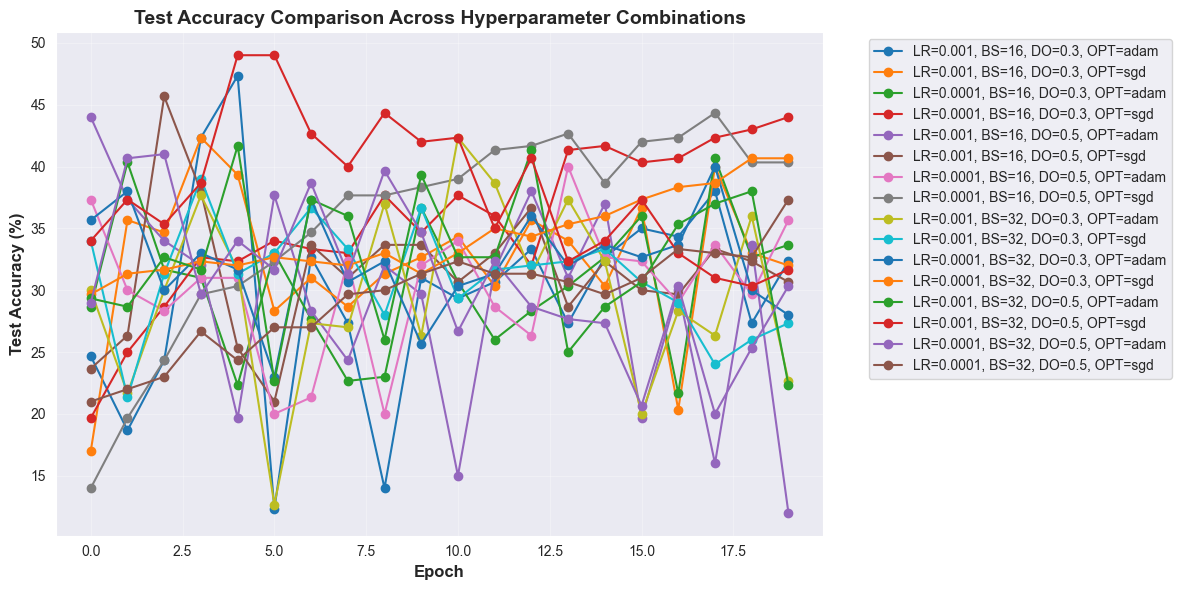

Best configuration achieved 44.00% accuracy


In [21]:
# Plot comparison of all parameter combinations
fig, ax = plt.subplots(figsize=(12, 6))

for i, result in enumerate(results):
    params_str = f"LR={result['params']['learning_rate']}, BS={result['params']['batch_size']}, DO={result['params']['dropout']}, OPT={result['params']['optimizer']}"
    ax.plot(result['test_accs'], label=params_str, marker='o')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Test Accuracy Comparison Across Hyperparameter Combinations', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best configuration achieved {best_acc:.2f}% accuracy")

## 9. Detailed Evaluation of Best Model

In [22]:
# Create test loader with best batch size
test_loader = DataLoader(
    test_dataset,
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS
)

# Evaluate best model
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, all_preds, all_labels = evaluate_model(
    best_model, test_loader, criterion, device
)

print(f"\nBest Model Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]


Best Model Test Results:
Test Loss: 1.5377
Test Accuracy: 44.00%


In [23]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))


Classification Report:
                   precision    recall  f1-score   support

       Platymonas       0.31      0.69      0.43        52
        Chlorella       0.24      0.10      0.14        40
Dunaliella salina       0.50      0.69      0.58       102
        Effrenium       0.00      0.00      0.00        28
     Porphyridium       0.00      0.00      0.00        13
    Haematococcus       0.81      0.34      0.48        65

         accuracy                           0.44       300
        macro avg       0.31      0.30      0.27       300
     weighted avg       0.43      0.44      0.39       300



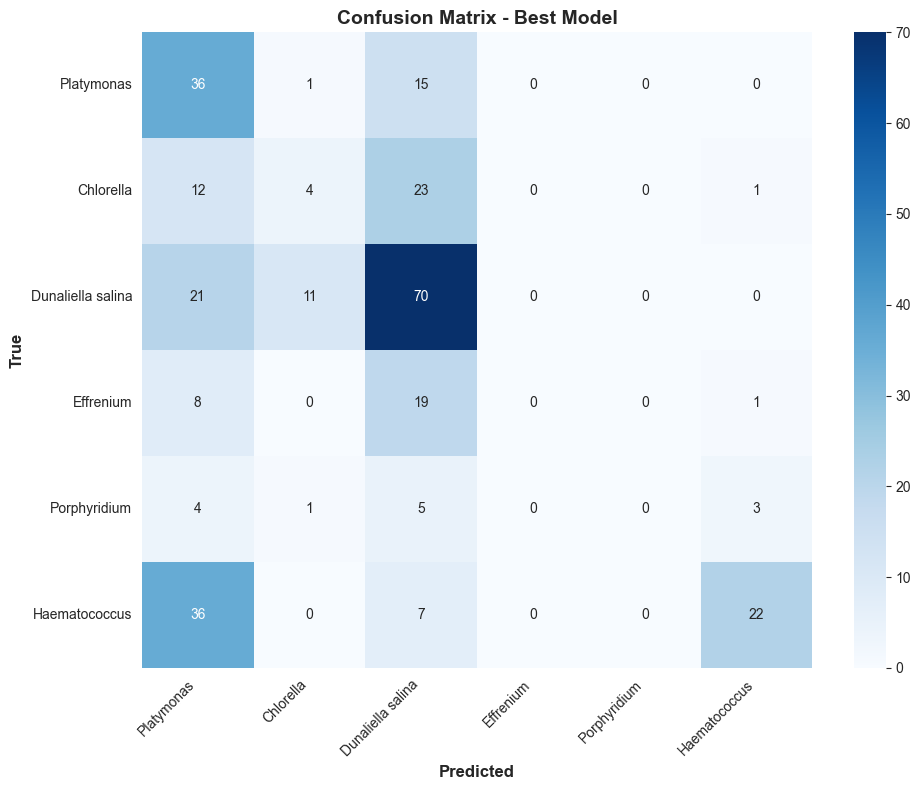

In [24]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('True', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Best Model', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 10. Save Best Model

In [25]:
# Save the best model
model_path = SAVE_DIR / 'best_algae_cnn.pth'
torch.save({
    'model_state_dict': best_model.state_dict(),
    'best_params': best_params,
    'test_accuracy': best_acc,
    'class_names': CLASS_NAMES
}, model_path)

print(f"Best model saved to: {model_path}")
print(f"\nModel Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Best model saved to: ..\outputs\models\best_algae_cnn.pth

Model Parameters:
  batch_size: 16
  dropout: 0.3
  learning_rate: 0.0001
  num_epochs: 20
  optimizer: sgd


## 11. Summary

In [26]:
print("="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   • Training samples: {len(train_dataset)}")
print(f"   • Test samples: {len(test_dataset)}")
print(f"   • Number of classes: {NUM_CLASSES}")

print(f"\n🏆 Best Model Performance:")
print(f"   • Test Accuracy: {best_acc:.2f}%")
print(f"   • Test Loss: {test_loss:.4f}")

print(f"\n⚙️ Best Hyperparameters:")
for key, value in best_params.items():
    print(f"   • {key}: {value}")

print(f"\n💾 Model saved to: {model_path}")
print("="*80)

TRAINING SUMMARY

📊 Dataset:
   • Training samples: 700
   • Test samples: 300
   • Number of classes: 6

🏆 Best Model Performance:
   • Test Accuracy: 44.00%
   • Test Loss: 1.5377

⚙️ Best Hyperparameters:
   • batch_size: 16
   • dropout: 0.3
   • learning_rate: 0.0001
   • num_epochs: 20
   • optimizer: sgd

💾 Model saved to: ..\outputs\models\best_algae_cnn.pth
